<a href="https://colab.research.google.com/github/ailuj/BayesianDeepLearning/blob/playground/Theano_VI_HMC_Regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

from google.colab import drive, files
drive.mount('/content/drive',force_remount=True)
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"batuhanipekci","key":"8d50f8f4e095ae646c2912649292ed60"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d wendykan/lending-club-loan-data 


lending-club-loan-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd

from zipfile import ZipFile
zip_file = ZipFile('lending-club-loan-data.zip')
zip_file.namelist()
loan = pd.read_csv(zip_file.open('loan.csv'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
loan = loan[(loan['loan_status'] != 'Current')]
selected = loan[['total_pymnt', 'annual_inc', 'int_rate','loan_amnt','purpose', 'loan_status']]
selected = selected.dropna()
target = selected.apply(lambda x: (x['total_pymnt'] - x['loan_amnt'])/x['loan_amnt'], axis = 1)
data = selected.drop(columns = ['total_pymnt', 'loan_amnt', 'loan_status'])
data = pd.get_dummies(data)
data.head()

,annual_inc,int_rate,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,24000.0,10.65,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,30000.0,15.27,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12252.0,15.96,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,49200.0,13.49,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,36000.0,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

scaler_tr = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler_tr.transform(X_train)

scaler_test = preprocessing.MinMaxScaler().fit(X_test)
X_test = scaler_test.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
X_train = np.array(X_train, dtype = theano.config.floatX)
y_train = np.array(y_train, dtype = theano.config.floatX)
X_test = np.array(X_test, dtype = theano.config.floatX)
y_test = np.array(y_test, dtype = theano.config.floatX)


In [0]:
def construct_nn(ann_input, ann_output):

  n_hidden = 100
    
    # Initialize random weights between each layer
  init_1 = np.random.randn(data.shape[1], n_hidden).astype(theano.config.floatX)
  init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
  init_3 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
  init_out = np.random.randn(n_hidden).astype(theano.config.floatX)
  
  with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(data.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from 2nd to 3rd layer
        weights_2_3 = pm.Normal('w_2_3', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_3)
        
        # Weights from hidden layer to output
        weights_3_out = pm.Normal('w_3_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_3 = pm.math.tanh(pm.math.dot(act_2, 
                                         weights_2_3))
        act_out = pm.math.dot(act_3, weights_3_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Normal('out', 
                           act_out,
                           observed=ann_output,
                           total_size=y_train.shape[0] # IMPORTANT for minibatches
                          )
        return neural_network

  
# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)
neural_network = construct_nn(ann_input, ann_output)

# Usually we would add a constant b to the inputs but I omitted it here to keep the code cleaner.

In [0]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

Variational Inference

In [0]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=1000, method=inference)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 1.1937e+07: 100%|██████████| 1000/1000 [55:59<00:00,  3.36s/it]
Finished [100%]: Average Loss = 1.191e+07


CPU times: user 1h 19min 35s, sys: 8min 16s, total: 1h 27min 52s
Wall time: 56min 6s


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 51336, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 59774, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
import matplotlib.pyplot as plt

plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

NameError: ignored

Sampling from VI

In [0]:
trace = approx.sample(draws=1000)


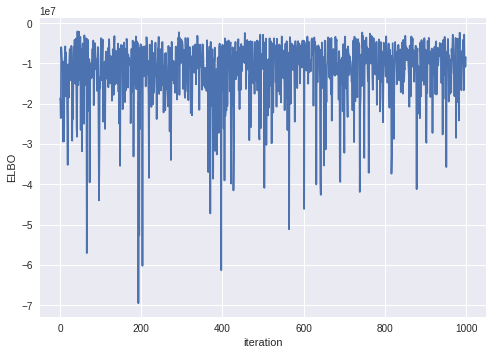

In [0]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Prediction

In [0]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=200, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """


In [0]:
pred

NameError: ignored

In [0]:
import numpy as np
mse = (np.outer(y_test - pred,y_test - pred)).mean()
mse

NameError: ignored

In [0]:
print('MSE = {}%'.format(((y_test - pred)^2).mean()))


TypeError: ignored

**HAMILTONIAN MONTE CARLO**

After constructing the model, we may also choose to sample from the posterior by HMC

In [0]:
with neural_network:
    step = pm.step_methods.HamiltonianMC(vars=neural_network.vars)
    trace_HMC = pm.sample(100, step)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
HamiltonianMC: [w_3_out, w_2_3, w_1_2, w_in_1]
  1%|          | 4/600 [06:15<16:53:17, 102.01s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks
